In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [13]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  !unzip -q data.zip
  image_path = "data"
  %cp "/content/drive/My Drive/autoencoder-training/model_layers.py" .
  %cp "/content/drive/My Drive/autoencoder-training/baseline_model.py" .
  import baseline_model
  import model_layers
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"
  from resnet_autoencoder_training import baseline_model

Mounted at /content/drive
replace __MACOSX/data/._valid? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
batchsize = 128

#tfms = get_transforms(do_flip = True)
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0, 
                      p_lighting=0.75)
src = (ImageImageList.from_folder(image_path).split_by_folder().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

In [0]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[0:8]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(resnet, AdaptiveConcatPool2d(), nn.Flatten())

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

In [0]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()

        self.bottleneck = nn.Sequential(nn.Linear(1024, 24 * 8 * 8),
                                        model_layers.reshape([-1,24,8,8])
                                        )

        self.up1 = model_layers.Upsample(24,12)
        self.up2 = model_layers.Upsample(12,3)

    def forward(self,x):
        x = self.bottleneck(x)
        x = self.up1(x)
        x = self.up2(x)
        return x

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = encoder()
        self.decoder = decoder()

    def encode(self, x): return self.encoder(x)
    def decode(self, x): return torch.clamp(self.decoder(x), min = 0, max = 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.clamp(x, min = 0, max = 1)


In [23]:
ae = autoencoder()
learn = Learner(data, ae, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [24]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.069312,0.070577,01:28
1,0.057586,0.059034,01:28
2,0.053160,0.054193,01:28
3,0.049884,0.051350,01:26
4,0.048766,0.050672,01:25


In [0]:
learn.unfreeze()

In [63]:
learn.split(lambda m: (m.encoder.encoder[0][1], m.encoder.encoder[0][2], m.encoder.encoder[0][3], m.encoder.encoder[0][4], m.encoder.encoder[0][5], 
                       m.encoder.encoder[0][6], m.encoder.encoder[0][7], m.encoder.encoder[1], m.decoder))
print("unfroze")

unfroze


In [74]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02
Min loss divided by 10: 3.02E-02


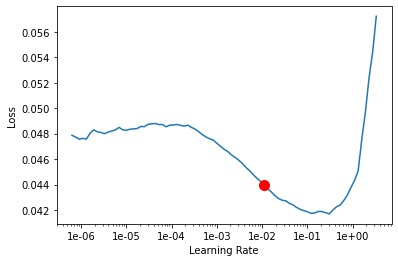

In [75]:
learn.recorder.plot(suggestion = True)

In [78]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr = slice(1e-05, 1e-02))

epoch,train_loss,valid_loss,time
0,0.023705,0.023769,01:38
1,0.015824,0.018011,01:35
2,0.013271,0.015160,01:34
3,0.012560,0.016291,01:34
4,0.011778,0.014408,01:34
5,0.010691,0.012336,01:34
6,0.009615,0.011106,01:34
7,0.009104,0.010554,01:34
8,0.008737,0.010283,01:33
9,0.008593,0.010233,01:38


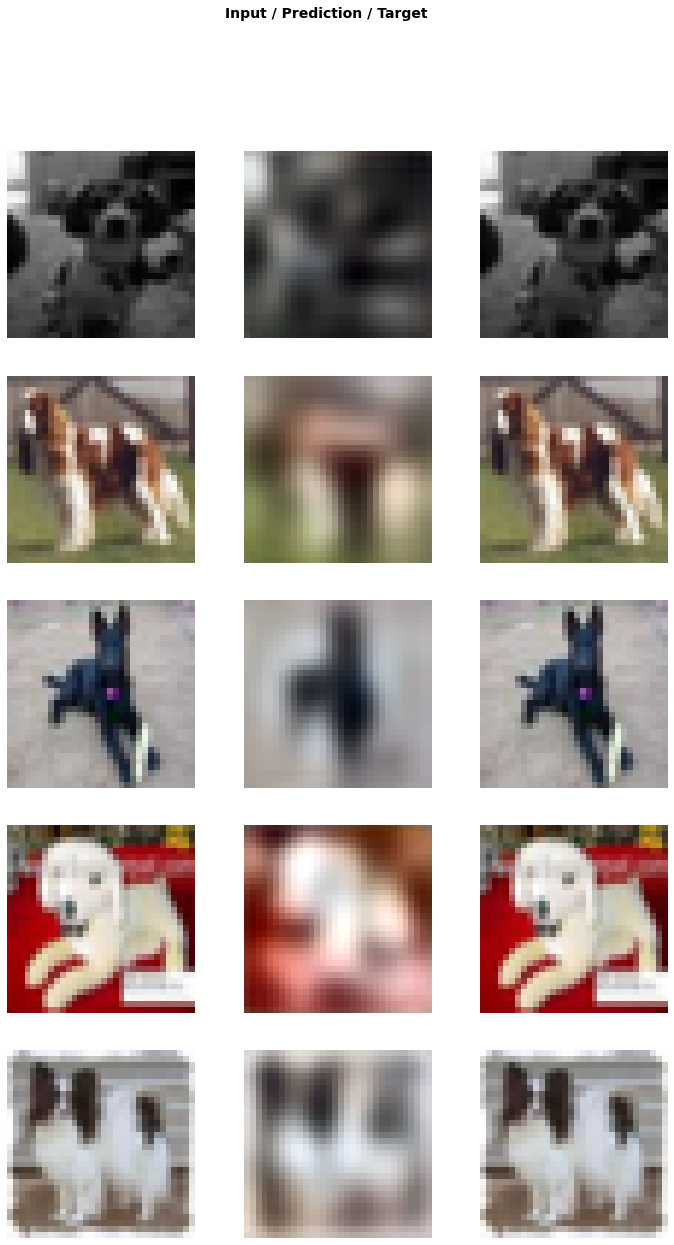

In [79]:
learn.show_results()

In [80]:
learn.fit_one_cycle(20, max_lr = slice(1e-06, 1e-02))

epoch,train_loss,valid_loss,time
0,0.008669,0.010353,01:37
1,0.008643,0.010282,01:36
2,0.008772,0.010231,01:35
3,0.008797,0.010479,01:34
4,0.008854,0.010436,01:34
5,0.008652,0.010615,01:33
6,0.008436,0.010091,01:34
7,0.008303,0.010235,01:33
8,0.007882,0.009747,01:33
9,0.007675,0.009734,01:34


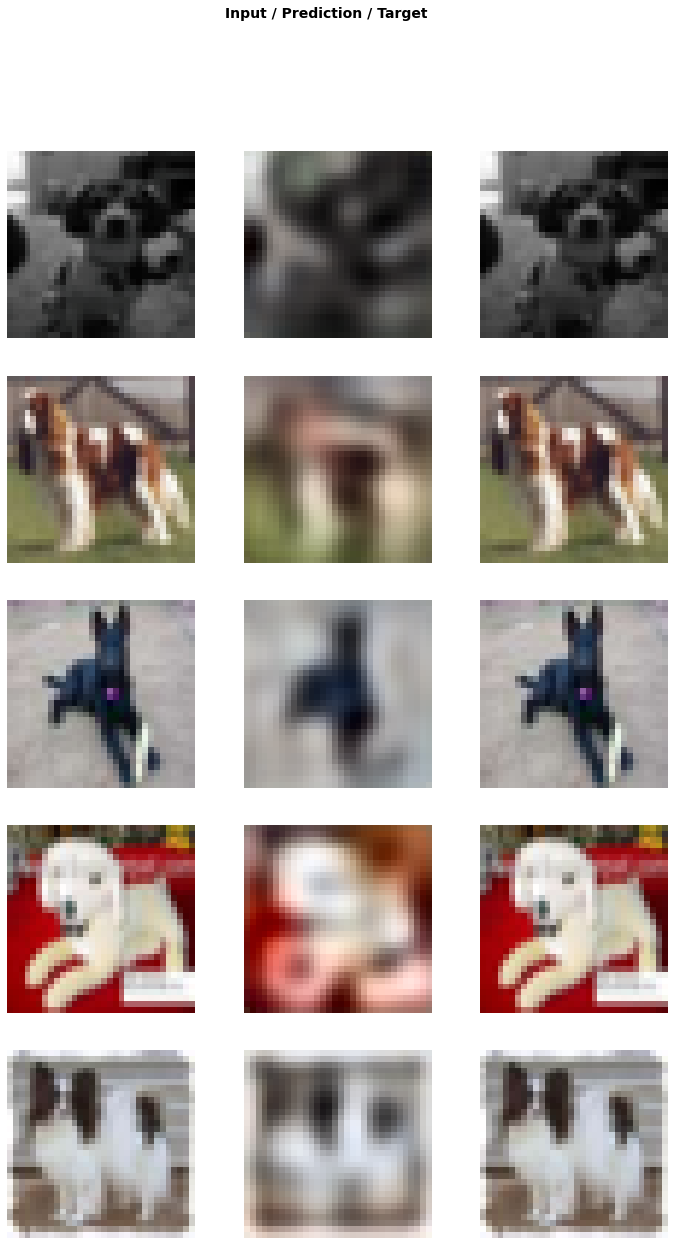

In [81]:
learn.show_results()